<a href="https://colab.research.google.com/github/Jopat2409/com3610_notebooks/blob/main/LUKE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
%pip install seqeval
%pip install transformers
%pip install datasets

In [3]:
import torch
import seqeval.metrics
from transformers import AutoTokenizer, LukeForEntitySpanClassification, pipeline, LukeTokenizer
from datasets import load_dataset, Dataset

c:\Users\Joe\Documents\projects\com3610_notebooks\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
TOKEN_TO_ID = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
ID_TO_TOKEN = {v: k for k, v in TOKEN_TO_ID.items()}
PIPELINE_KWARGS = {"ignore_labels": []}

# The model to work on
NER_MODEL = "studio-ousia/luke-large-finetuned-conll-2003"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = LukeTokenizer.from_pretrained(NER_MODEL, device=device)
model = LukeForEntitySpanClassification.from_pretrained(NER_MODEL)


Some weights of the model checkpoint at studio-ousia/luke-large-finetuned-conll-2003 were not used when initializing LukeForEntitySpanClassification: ['luke.embeddings.position_ids']
- This IS expected if you are initializing LukeForEntitySpanClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LukeForEntitySpanClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def get_word_bounds(sentence: str):
  first_word = next(i for i in range(len(sentence)) if sentence[i] != ' ')
  spaces = [first_word + i for i, ch in enumerate(sentence[first_word:]) if ch==' ']
  return [first_word] + [sp+1 for sp in spaces], spaces + [len(sentence)]

Run to double check that it aligns with the expected values from the LUKE

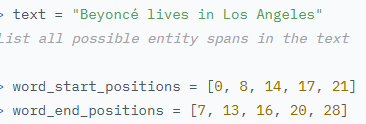

In [7]:
print(get_word_bounds("Beyoncé lives in Los Angeles"))

([0, 8, 14, 17, 21], [7, 13, 16, 20, 28])


Next we need to extract all of the possible entity spans of a certain length (128 as used in the LUKE example)

In [8]:
def extract_entity_spans(sentence: str):
  start_positions, end_positions = get_word_bounds(sentence)
  return [(start, end) for i, start in enumerate(start_positions) for end in end_positions[i:] if end-start<=128]

In [9]:
print(extract_entity_spans("Beyoncé lives in Los Angeles"))

[(0, 7), (0, 13), (0, 16), (0, 20), (0, 28), (8, 13), (8, 16), (8, 20), (8, 28), (14, 16), (14, 20), (14, 28), (17, 20), (17, 28), (21, 28)]


In [23]:
data = load_dataset("conll2003", split="test")
data_joined = data.map(lambda x: {"tokens": " ".join(x["tokens"])})

data_joined = data_joined.add_column("entity_spans", [extract_entity_spans(e) for e in data_joined['tokens']])
print(data_joined["entity_spans"][0])


[[0, 6], [0, 8], [0, 14], [0, 18], [0, 24], [0, 28], [0, 30], [0, 36], [0, 39], [0, 48], [0, 55], [0, 57], [7, 8], [7, 14], [7, 18], [7, 24], [7, 28], [7, 30], [7, 36], [7, 39], [7, 48], [7, 55], [7, 57], [9, 14], [9, 18], [9, 24], [9, 28], [9, 30], [9, 36], [9, 39], [9, 48], [9, 55], [9, 57], [15, 18], [15, 24], [15, 28], [15, 30], [15, 36], [15, 39], [15, 48], [15, 55], [15, 57], [19, 24], [19, 28], [19, 30], [19, 36], [19, 39], [19, 48], [19, 55], [19, 57], [25, 28], [25, 30], [25, 36], [25, 39], [25, 48], [25, 55], [25, 57], [29, 30], [29, 36], [29, 39], [29, 48], [29, 55], [29, 57], [31, 36], [31, 39], [31, 48], [31, 55], [31, 57], [37, 39], [37, 48], [37, 55], [37, 57], [40, 48], [40, 55], [40, 57], [49, 55], [49, 57], [56, 57]]


In [24]:
from torch.utils.data import Dataset, DataLoader

class EntitySpanDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        tokens = row["tokens"]
        entity_spans = row["entity_spans"]  # [(start1, end1), (start2, end2), ...]
        labels = row.get("labels", None)  # Optional

        # Tokenize and encode
        encoded = self.tokenizer(
            tokens,
            entity_spans=[tuple(span) for span in entity_spans],
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Add labels if they exist
        if labels is not None:
            encoded["labels"] = torch.tensor(labels)

        return {key: val.squeeze(0) for key, val in encoded.items()}

test_dataset = EntitySpanDataset(data_joined, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [30]:
model.to(device)
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        # Move batch to GPU
        batch = {key: val.to(device) for key, val in batch.items()}
        predictions = torch.argmax(model(**batch).logits, dim=-1).cpu().numpy()
        all_predictions.extend(predictions)



{'input_ids': tensor([[    0, 13910,  3376,  ...,     1,     1,     1],
        [    0,  7157,   757,  ...,     1,     1,     1],
        [    0,  6019,    12,  ...,     1,     1,     1],
        ...,
        [    0,   436,  4875,  ...,     1,     1,     1],
        [    0,   384,  4308,  ...,     1,     1,     1],
        [    0,    20,   320,  ...,     1,     1,     1]], device='cuda:0'), 'entity_ids': tensor([[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2,

In [37]:
import json

with open("luke.json", "w") as f:
    json.dump([list(map(lambda x: model.config.id2label[x] if model.config.id2label[x] != 'NIL' else 'O', l.tolist())) for l in all_predictions], f)

In [46]:
for i, row in enumerate(data_joined):
    print(row["tokens"])
    print(list(zip(row["entity_spans"], map(lambda x: model.config.id2label[x] if model.config.id2label[x] != 'NIL' else 'O', all_predictions[i].tolist()))))

SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
[([0, 6], 'O'), ([0, 8], 'O'), ([0, 14], 'O'), ([0, 18], 'O'), ([0, 24], 'O'), ([0, 28], 'O'), ([0, 30], 'O'), ([0, 36], 'O'), ([0, 39], 'O'), ([0, 48], 'O'), ([0, 55], 'O'), ([0, 57], 'O'), ([7, 8], 'O'), ([7, 14], 'O'), ([7, 18], 'O'), ([7, 24], 'O'), ([7, 28], 'O'), ([7, 30], 'O'), ([7, 36], 'O'), ([7, 39], 'O'), ([7, 48], 'O'), ([7, 55], 'O'), ([7, 57], 'O'), ([9, 14], 'LOC'), ([9, 18], 'O'), ([9, 24], 'O'), ([9, 28], 'O'), ([9, 30], 'O'), ([9, 36], 'O'), ([9, 39], 'O'), ([9, 48], 'O'), ([9, 55], 'O')]
Nadim Ladki
[([0, 5], 'O'), ([0, 11], 'PER'), ([6, 11], 'O')]
AL-AIN , United Arab Emirates 1996-12-06
[([0, 6], 'LOC'), ([0, 8], 'O'), ([0, 15], 'O'), ([0, 20], 'O'), ([0, 29], 'O'), ([0, 40], 'O'), ([7, 8], 'O'), ([7, 15], 'O'), ([7, 20], 'O'), ([7, 29], 'O'), ([7, 40], 'O'), ([9, 15], 'O'), ([9, 20], 'O'), ([9, 29], 'LOC'), ([9, 40], 'O'), ([16, 20], 'O'), ([16, 29], 'O'), ([16, 40], 'O'), ([21, 29], 'O'), ([21, 40], 'O'), 